# Data Collection

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import json
import time
from urllib.parse import urljoin
import re

def download_anthem_translation(country_code):

    url = f"https://nationalanthems.info/{country_code}.htm"

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=headers)

        # Skip only for actual errors (4xx and 5xx), but allow 206 (Partial Content)
        if response.status_code >= 400:
            print(f"Skipping {country_code}: HTTP {response.status_code}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        # Find all translation divs
        divs = soup.find_all("div", class_="collapseomatic_content")

        # English translation is the last div in the list
        if divs:
            return divs[-1].get_text(separator="\n", strip=True)

        return "English translation not found."

    except requests.exceptions.RequestException as e:
        print(f"Skipping {country_code}: {e}")
        return None

def download_anthem_mp3(country_code, country_name, output_dir="anthems"):
    """
    Download the MP3 file of a national anthem

    Args:
        country_code (str): The 2-letter country code
        country_name (str): The full country name for naming the file
        output_dir (str): Directory to save the file

    Returns:
        str: Path to the downloaded file, or None if download failed
    """
    mp3_url = f"https://nationalanthems.info/{country_code}.mp3"

    # Create a safe filename from the country name
    safe_name = sanitize_filename(country_name)
    output_path = os.path.join(output_dir, f"{safe_name}.mp3")

    # Add browser-like headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': '*/*',
        'Accept-Encoding': 'identity;q=1, *;q=0',
        'Accept-Language': 'en-US,en;q=0.5',
        'Connection': 'keep-alive',
        'Range': 'bytes=0-',
    }

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    try:
        response = requests.get(mp3_url, headers=headers, stream=True)
        if response.status_code >= 400:  # Skip this country if there's an issue
            print(f"Skipping {country_code}: HTTP {response.status_code}")
            return None

        # Check if we actually got MP3 content
        content_type = response.headers.get('Content-Type', '')
        if 'audio' not in content_type and response.headers.get('Content-Length', '0') == '0':
            print(f"No MP3 content found for {country_name} ({country_code}). Content-Type: {content_type}")
            return None

        # Save the MP3 file
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        # Verify the file has actual content
        if os.path.getsize(output_path) < 1000:  # Less than 1KB is suspicious
            with open(output_path, 'rb') as f:
                content = f.read()
                if b'<!DOCTYPE html>' in content or b'<html' in content:
                    print(f"Received HTML instead of MP3 for {country_name} ({country_code})")
                    os.remove(output_path)
                    return None

        return output_path

    except requests.exceptions.RequestException as e:
        print(f"Error downloading MP3 for {country_name} ({country_code}): {e}")
        return None

def get_country_name(country_code):
    """Get the full country name from its code by scraping the website index"""
    # Add browser-like headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
    }

    try:
        index_url = "https://nationalanthems.info/"
        response = requests.get(index_url, headers=headers)
        if response.status_code != 200:  # Skip this country if there's an issue
            print(f"Skipping {country_code}: HTTP {response.status_code}")
            return None

        soup = BeautifulSoup(response.text, 'html.parser')

        # Look for links that contain the country code
        links = soup.find_all('a', href=lambda href: href and f"{country_code}.htm" in href)
        if links:
            return links[0].get_text().strip()
    except Exception as e:
        print(f"Error getting country name for {country_code}: {e}")

    # Fallback if we can't find the name
    return country_code.upper()

def sanitize_filename(filename):
    """
    Convert country name to a safe filename

    Args:
        filename (str): The original filename (country name)

    Returns:
        str: A sanitized filename
    """
    # Replace unsafe characters
    safe_name = re.sub(r'[\\/*?:"<>|]', "", filename)
    # Replace spaces with underscores
    safe_name = safe_name.replace(" ", "_")
    # Remove any other problematic characters
    safe_name = re.sub(r'[^\w\-\.]', "", safe_name)
    # Ensure it's not empty
    if not safe_name:
        return "unknown_country"
    return safe_name

def create_metadata(processed_countries, output_file="anthem_metadata.json"):
    """
    Create a metadata file for the downloaded anthems

    Args:
        processed_countries (list): List of dictionaries with country info
        output_file (str): Path to save the metadata file
    """
    metadata = {}

    for country in processed_countries:
        code = country['code']
        name = country['name']
        safe_name = sanitize_filename(name)

        translation_path = os.path.join("translations", f"{safe_name}.txt")
        mp3_path = os.path.join("anthems", f"{safe_name}.mp3")
        mp3_url = f"https://nationalanthems.info/{code}.mp3"

        metadata[name] = {
            "country_code": code,
            "translation_file": translation_path if os.path.exists(translation_path) else None,
            "mp3_file": mp3_path if os.path.exists(mp3_path) else None,
            "mp3_url": mp3_url,
            "source_url": f"https://nationalanthems.info/{code}.htm"
        }

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=4)

    return output_file

def load_country_codes_from_json(json_file_path):
    """
    Load country codes from a JSON file

    Args:
        json_file_path (str): Path to the JSON file containing country codes

    Returns:
        list: List of country codes
    """
    try:
        with open(json_file_path, 'r') as f:
            data = json.load(f)

        # Handle different possible JSON structures
        country_codes = []

        # If it's a simple list of country codes
        if isinstance(data, list):
            country_codes = [code.lower() for code in data if isinstance(code, str)]

        # If it's a dictionary with country codes as keys
        elif isinstance(data, dict):
            country_codes = [code.lower() for code in data.keys() if isinstance(code, str)]

            # Or if it's a list of dictionaries with a 'code' field
            if not country_codes and 'countries' in data:
                if isinstance(data['countries'], list):
                    for country in data['countries']:
                        if isinstance(country, dict) and 'code' in country:
                            country_codes.append(country['code'].lower())

        return country_codes

    except Exception as e:
        print(f"Error loading country codes from JSON file: {e}")
        return []

def main(json_file_path=None, country_codes=None, subset_size=None):
    """
    Main function to download anthem translations and MP3 files

    Args:
        json_file_path (str, optional): Path to JSON file with country codes
        country_codes (list, optional): Direct list of country codes to process
        subset_size (int, optional): Number of countries to process (if None, process all)
    """
    # Create directories
    os.makedirs("translations", exist_ok=True)
    os.makedirs("anthems", exist_ok=True)
    with open(json_file_path, 'r') as f:
            data = json.load(f)

    # Determine country codes from either JSON file or direct input
    if json_file_path and os.path.exists(json_file_path):
        codes = load_country_codes_from_json(json_file_path)
        print(f"Loaded {len(codes)} country codes from {json_file_path}")
    elif country_codes:
        codes = country_codes
        print(f"Using {len(codes)} provided country codes")
    else:
        codes = ["us", "gb", "fr", "de", "jp", "ga", "ca", "au"]
        print(f"No country codes provided, using default set of {len(codes)} codes")

    processed_countries = []
    successful_mp3 = 0
    successful_translations = 0
    attempted = 0

    # Continue trying countries until we reach the subset size or run out of countries
    country_index = 0
    while (subset_size is None or len(processed_countries) < subset_size) and country_index < len(codes):
        # Get the current country code
        code = codes[country_index]
        country_index += 1
        attempted += 1

        #print(f"\nProcessing country {attempted}: {code}")

        # Get the country name
        country_name = data.get(code.upper(),"Unknown Country")
        #print(f"Country name: {country_name}")

        country_data = {
            'code': code,
            'name': country_name,
            'translation_success': False,
            'mp3_success': False
        }

        # Create a safe filename
        safe_name = sanitize_filename(country_name)

        # Download translation
        translation = download_anthem_translation(code)
        if translation:
            with open(f"translations/{safe_name}.txt", 'w', encoding='utf-8') as f:
                f.write(translation)
            #print(f"✓ Saved translation for {country_name}")
            country_data['translation_success'] = True
            successful_translations += 1
        else:
            print(f"✗ Failed to get translation for {country_name}")

        # Download MP3
        mp3_path = download_anthem_mp3(code, safe_name)
        if mp3_path:
            #print(f"✓ Downloaded MP3 for {country_name}")
            country_data['mp3_success'] = True
            successful_mp3 += 1
        else:
            print(f"✗ Failed to download MP3 for {country_name}")

        # Add to our list of processed countries if either download succeeded
        if country_data['translation_success'] and country_data['mp3_success']:
            processed_countries.append(country_data)
            print(f"Progress: {len(processed_countries)}/{subset_size if subset_size else len(codes)}")

        # Be nice to the server
        time.sleep(2)

    # Create metadata file
    metadata_file = create_metadata(processed_countries)
    print(f"\nCreated metadata file: {metadata_file}")

    # Summary
    print(f"\nSummary:")
    print(f"- Total countries attempted: {attempted}")
    print(f"- Total countries processed successfully: {len(processed_countries)}")
    print(f"- Successful translations: {successful_translations}")
    print(f"- Successful MP3 downloads: {successful_mp3}")

    return processed_countries

if __name__ == "__main__":
    # Example usage with a JSON file and a specific limit
    main(json_file_path='/kaggle/input/country-flags/countries.json', subset_size=100)


Loaded 255 country codes from /kaggle/input/country-flags/countries.json
Progress: 1/100
Progress: 2/100
Progress: 3/100
Progress: 4/100
Progress: 5/100
Progress: 6/100
Progress: 7/100
Progress: 8/100
Skipping aq: HTTP 404
✗ Failed to get translation for Antarctica
Skipping aq: HTTP 404
✗ Failed to download MP3 for Antarctica
Progress: 9/100
Progress: 10/100
Progress: 11/100
Progress: 12/100
Progress: 13/100
Progress: 14/100
Progress: 15/100
Progress: 16/100
Progress: 17/100
Progress: 18/100
Progress: 19/100
Progress: 20/100
Progress: 21/100
Progress: 22/100
Progress: 23/100
Progress: 24/100
Progress: 25/100
Progress: 26/100
Progress: 27/100
Progress: 28/100
Skipping bq: HTTP 404
✗ Failed to get translation for Caribbean Netherlands
Skipping bq: HTTP 404
✗ Failed to download MP3 for Caribbean Netherlands
Progress: 29/100
Progress: 30/100
Progress: 31/100
Skipping bv: HTTP 404
✗ Failed to get translation for Bouvet Island
Skipping bv: HTTP 404
✗ Failed to download MP3 for Bouvet Island


In [ ]:
import shutil

shutil.make_archive("anthems", 'zip', "/kaggle/working/anthems")
shutil.make_archive("translations", 'zip', "/kaggle/working/translations")

'/kaggle/working/translations.zip'

# Visual Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import xml.etree.ElementTree as ET
import re
import json
import colorsys
from collections import Counter
import math

def extract_svg_dimensions(svg_file):
    """Extract width and height from SVG file"""
    try:
        tree = ET.parse(svg_file)
        root = tree.getroot()

        # Try to get dimensions from viewBox first
        if 'viewBox' in root.attrib:
            viewbox = root.attrib['viewBox']
            values = [float(x) for x in viewbox.split()]
            if len(values) == 4:  # viewBox format: min-x min-y width height
                width, height = values[2], values[3]
                return width, height

        # If viewBox not available or invalid, try width and height attributes
        if 'width' in root.attrib and 'height' in root.attrib:
            width = root.attrib['width']
            height = root.attrib['height']

            # Remove units if present
            width = float(re.findall(r'[\d.]+', width)[0])
            height = float(re.findall(r'[\d.]+', height)[0])

            return width, height

        # If neither is available
        return None, None

    except Exception as e:
        print(f"Error processing {svg_file}: {e}")
        return None, None


In [ ]:
def analyze_svg_colors(svg_file, num_colors=5):
    """Extract dominant colors from SVG file"""
    try:
        with open(svg_file, 'r') as f:
            svg_content = f.read()

        # Find all color specifications in the SVG
        hex_colors = re.findall(r'#[0-9a-fA-F]{6}|#[0-9a-fA-F]{3}', svg_content)
        rgb_colors = re.findall(r'rgb\(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\)', svg_content)

        # Convert to RGB format
        colors = []
        for hex_color in hex_colors:
            hex_color = hex_color.lstrip('#')
            if len(hex_color) == 3:
                hex_color = ''.join([c*2 for c in hex_color])
            colors.append(tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)))

        for rgb_color in rgb_colors:
            colors.append(tuple(map(int, rgb_color)))

        # Count occurrences
        color_counter = Counter(colors)
        return color_counter.most_common(num_colors)

    except Exception as e:
        print(f"Error extracting colors from {svg_file}: {e}")
        return []


In [ ]:
def rgb_to_hsl(rgb):
    """Convert RGB to HSL color space"""
    r, g, b = [x/255.0 for x in rgb]
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return (h*360, s*100, l*100)  # Convert to degrees and percentages

def analyze_flag_dataset(flag_directory):
    """Analyze flags from a directory of SVG files"""
    flag_data = []

    for filename in os.listdir(flag_directory):
        if filename.endswith('.svg'):
            country = os.path.splitext(filename)[0]
            file_path = os.path.join(flag_directory, filename)

            width, height = extract_svg_dimensions(file_path)
            if width and height:
                aspect_ratio = width / height

                # Get color information
                dominant_colors = analyze_svg_colors(file_path)
                num_colors = len(dominant_colors)

                # Calculate color diversity metrics
                hsl_values = [rgb_to_hsl(color[0]) for color in dominant_colors] if dominant_colors else []

                # Calculate hue diversity
                hues = [h for h, s, l in hsl_values if s > 10 and 10 < l < 90] if hsl_values else []  # Filter out near-white/black
                hue_diversity = np.std(hues) if hues else 0

                # Calculate average saturation and lightness
                avg_saturation = np.mean([s for _, s, _ in hsl_values]) if hsl_values else 0
                avg_lightness = np.mean([l for _, _, l in hsl_values]) if hsl_values else 0

                flag_data.append({
                    'Country': country,
                    'Width': width,
                    'Height': height,
                    'Aspect_Ratio': aspect_ratio,
                    'Num_Colors': num_colors,
                    'Hue_Diversity': hue_diversity,
                    'Avg_Saturation': avg_saturation,
                    'Avg_Lightness': avg_lightness
                })

    return pd.DataFrame(flag_data)


In [ ]:

def analyze_aspect_ratios(df):
    """Analyze aspect ratios"""
    # Group flags by common aspect ratios with a small tolerance
    def categorize_aspect_ratio(ratio):
        common_ratios = {
            1.0: "1:1 (Square)",
            1.5: "2:3",
            1.6: "8:5",
            1.667: "3:5",
            1.9: "19:10",
            2.0: "1:2"
        }

        # Find the closest common ratio
        for standard_ratio, name in common_ratios.items():
            if abs(ratio - standard_ratio) < 0.05:
                return name

        # If not a common ratio, format as decimal
        return f"Unique ({ratio:.3f})"

    df['Aspect_Ratio_Category'] = df['Aspect_Ratio'].apply(categorize_aspect_ratio)

    # Count frequencies of each category
    ratio_counts = df['Aspect_Ratio_Category'].value_counts()

    # Visualize distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Aspect_Ratio'], bins=20, kde=True)
    plt.axvline(x=1.5, color='r', linestyle='--', label='2:3 ratio')
    plt.axvline(x=1.667, color='g', linestyle='--', label='5:3 ratio')
    plt.axvline(x=2.0, color='b', linestyle='--', label='1:2 ratio')
    plt.title('Distribution of Flag Aspect Ratios')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig('aspect_ratio_distribution.png')

    # Create pie chart of ratio categories
    plt.figure(figsize=(10, 10))

    # Filter out categories with very small counts to avoid overcrowding
    significant_ratios = ratio_counts[ratio_counts > ratio_counts.sum() * 0.02]
    other_count = ratio_counts[~ratio_counts.index.isin(significant_ratios.index)].sum()

    if other_count > 0:
        significant_ratios['Other'] = other_count

    plt.pie(significant_ratios, labels=significant_ratios.index, autopct='%1.1f%%', startangle=90)
    plt.title('Common Flag Aspect Ratio Categories')
    plt.tight_layout()
    plt.savefig('aspect_ratio_categories_pie.png')

    return ratio_counts


In [ ]:

def analyze_color_properties(df):
    """Analyze color properties of flags"""
    # Visualize color count distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Num_Colors'], bins=range(1, max(df['Num_Colors'])+2), kde=False)
    plt.title('Number of Colors in National Flags')
    plt.xlabel('Number of Colors')
    plt.ylabel('Frequency')
    plt.xticks(range(1, max(df['Num_Colors'])+1))
    plt.tight_layout()
    plt.savefig('color_count_distribution.png')

    # Scatter plot of color count vs. aspect ratio
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Aspect_Ratio', y='Num_Colors', data=df)
    plt.title('Relationship Between Aspect Ratio and Number of Colors')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Number of Colors')
    plt.tight_layout()
    plt.savefig('aspect_ratio_vs_colors.png')

    # Analyze color properties - only if there are enough data points
    if len(df) > 3:  # Ensure we have enough data
        plt.figure(figsize=(12, 6))
        scatter = sns.scatterplot(x='Hue_Diversity', y='Avg_Saturation', size='Num_Colors',
                        hue='Aspect_Ratio_Category', data=df, sizes=(20, 200))

        # Rotate legend labels if needed
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

        plt.title('Color Properties of National Flags')
        plt.xlabel('Hue Diversity (Standard Deviation)')
        plt.ylabel('Average Saturation')
        plt.tight_layout()
        plt.savefig('color_properties.png')

    # Find correlations
    correlation_matrix = df[['Aspect_Ratio', 'Num_Colors', 'Hue_Diversity', 'Avg_Saturation', 'Avg_Lightness']].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Flag Properties')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')

    return correlation_matrix


In [ ]:

def analyze_continent_patterns(df, continent_mapping):
    """Analyze patterns by continent"""
    # Add continent information based on filename conversion to lowercase
    df['Country_Lower'] = df['Country'].str.lower()
    df['Continent'] = df['Country_Lower'].map(continent_mapping)

    # Check if we have mapped continents successfully
    if df['Continent'].isna().all():
        print("Warning: No continent mappings matched. Check country names in files vs. mapping dictionary.")
        return pd.DataFrame()  # Return empty DataFrame to avoid errors

    # Remove entries with no continent mapping
    df_with_continent = df.dropna(subset=['Continent'])

    if len(df_with_continent) == 0:
        print("Warning: No valid continent mappings. Skipping continent analysis.")
        return pd.DataFrame()

    # Group by continent and calculate mean values
    continent_stats = df_with_continent.groupby('Continent').agg({
        'Aspect_Ratio': 'mean',
        'Num_Colors': 'mean',
        'Hue_Diversity': 'mean',
        'Avg_Saturation': 'mean',
        'Avg_Lightness': 'mean'
    }).round(3)

    # Check if we have at least two continents for valid plots
    if len(continent_stats) >= 2:
        # Visualize aspect ratio by continent
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Continent', y='Aspect_Ratio', data=df_with_continent)
        plt.title('Flag Aspect Ratios by Continent')
        plt.xlabel('Continent')
        plt.ylabel('Aspect Ratio (Width/Height)')
        plt.xticks(rotation=45)  # Rotate labels to avoid overlap
        plt.tight_layout()
        plt.savefig('aspect_ratio_by_continent.png')

        # Visualize number of colors by continent
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Continent', y='Num_Colors', data=df_with_continent)
        plt.title('Number of Colors in Flags by Continent')
        plt.xlabel('Continent')
        plt.ylabel('Number of Colors')
        plt.xticks(rotation=45)  # Rotate labels to avoid overlap
        plt.tight_layout()
        plt.savefig('colors_by_continent.png')
    else:
        print("Warning: Insufficient continent data for boxplots.")

    return continent_stats


In [ ]:
def identify_outliers(df):
    """Identify unusual flags"""
    outliers = {}

    # Aspect ratio outliers (outside 1.5 IQR)
    Q1_aspect = df['Aspect_Ratio'].quantile(0.25)
    Q3_aspect = df['Aspect_Ratio'].quantile(0.75)
    IQR_aspect = Q3_aspect - Q1_aspect
    aspect_outliers = df[(df['Aspect_Ratio'] < Q1_aspect - 1.5 * IQR_aspect) |
                         (df['Aspect_Ratio'] > Q3_aspect + 1.5 * IQR_aspect)]
    outliers['Aspect Ratio Outliers'] = aspect_outliers[['Country', 'Aspect_Ratio']].sort_values('Aspect_Ratio')

    # Color count outliers
    Q1_colors = df['Num_Colors'].quantile(0.25)
    Q3_colors = df['Num_Colors'].quantile(0.75)
    IQR_colors = Q3_colors - Q1_colors
    color_outliers = df[(df['Num_Colors'] < Q1_colors - 1.5 * IQR_colors) |
                        (df['Num_Colors'] > Q3_colors + 1.5 * IQR_colors)]
    outliers['Color Count Outliers'] = color_outliers[['Country', 'Num_Colors']].sort_values('Num_Colors', ascending=False)

    # Combined outliers (exceptional in multiple ways)
    combined_outliers = df[((df['Aspect_Ratio'] < Q1_aspect - 1.5 * IQR_aspect) |
                            (df['Aspect_Ratio'] > Q3_aspect + 1.5 * IQR_aspect)) &
                           ((df['Num_Colors'] < Q1_colors - 1.5 * IQR_colors) |
                            (df['Num_Colors'] > Q3_colors + 1.5 * IQR_colors))]
    outliers['Combined Outliers'] = combined_outliers[['Country', 'Aspect_Ratio', 'Num_Colors']]

    return outliers


Analyzing flag data...
Analyzed 98 flags successfully.

--- Basic Statistics ---
              Width         Height  Aspect_Ratio  Num_Colors  Hue_Diversity  \
count      98.00000      98.000000     98.000000   98.000000      98.000000   
mean     3310.20798    1837.439776      1.658049    3.357143      80.088135   
std     21997.01273   11832.169686      0.244929    1.159897      49.363005   
min         3.00000       2.000000      1.000000    0.000000       0.000000   
25%        25.25000      17.250000      1.500000    3.000000      56.095827   
50%       511.00000     300.000000      1.500000    3.000000      88.871100   
75%      1000.00000     600.000000      2.000000    4.000000     125.079585   
max    216958.34000  116416.660000      2.000000    5.000000     153.697917   

       Avg_Saturation  Avg_Lightness  
count       98.000000      98.000000  
mean        61.125059      53.304789  
std         22.032284      14.015882  
min          0.000000       0.000000  
25%         

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Aspect_Ratio_Category
2:3               40
1:2               28
3:5               12
8:5                4
Unique (1.375)     2
Unique (1.429)     2
19:10              2
Unique (1.333)     2
Unique (1.321)     1
Unique (1.400)     1
Unique (1.389)     1
Unique (1.750)     1
Unique (1.154)     1
1:1 (Square)       1
Name: count, dtype: int64

--- Color Analysis ---


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


                Aspect_Ratio  Num_Colors  Hue_Diversity  Avg_Saturation  \
Aspect_Ratio        1.000000    0.254861       0.117182       -0.002808   
Num_Colors          0.254861    1.000000       0.395366        0.071087   
Hue_Diversity       0.117182    0.395366       1.000000        0.512093   
Avg_Saturation     -0.002808    0.071087       0.512093        1.000000   
Avg_Lightness      -0.097367   -0.366076      -0.457011       -0.422408   

                Avg_Lightness  
Aspect_Ratio        -0.097367  
Num_Colors          -0.366076  
Hue_Diversity       -0.457011  
Avg_Saturation      -0.422408  
Avg_Lightness        1.000000  

--- Continental Patterns ---
               Aspect_Ratio  Num_Colors  Hue_Diversity  Avg_Saturation  \
Continent                                                                
Africa                1.567       3.500        106.306          71.372   
Asia                  1.579       2.667         52.377          55.003   
Europe                1.579    

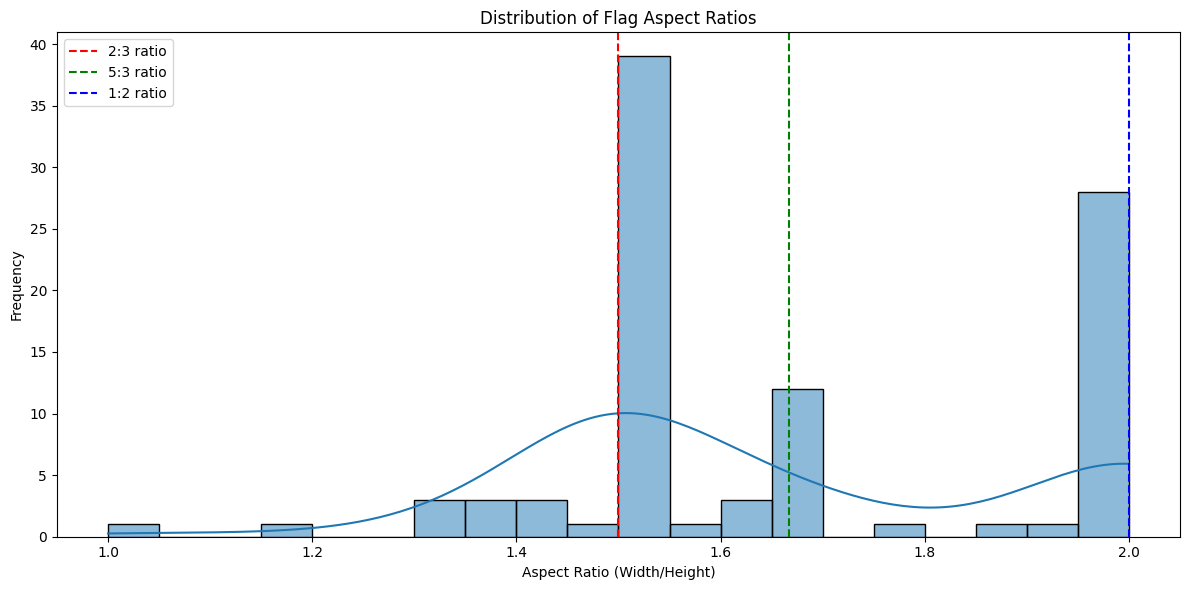

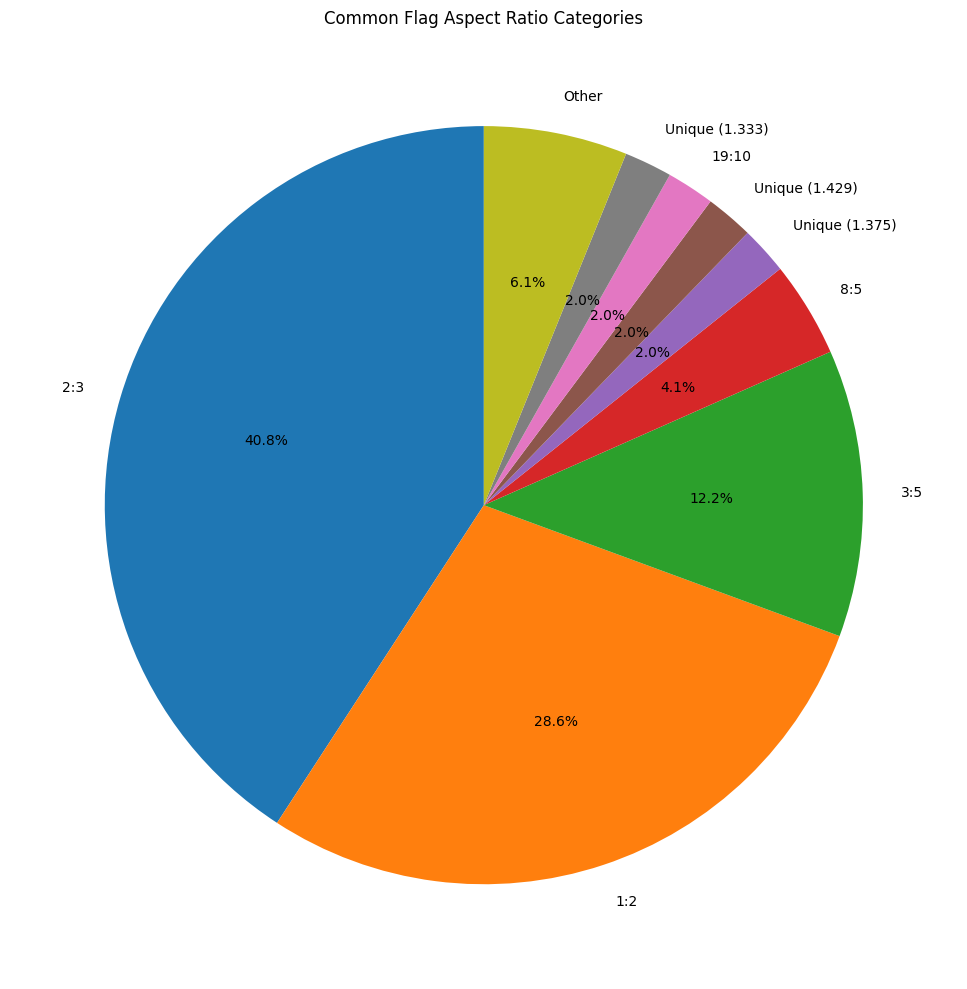

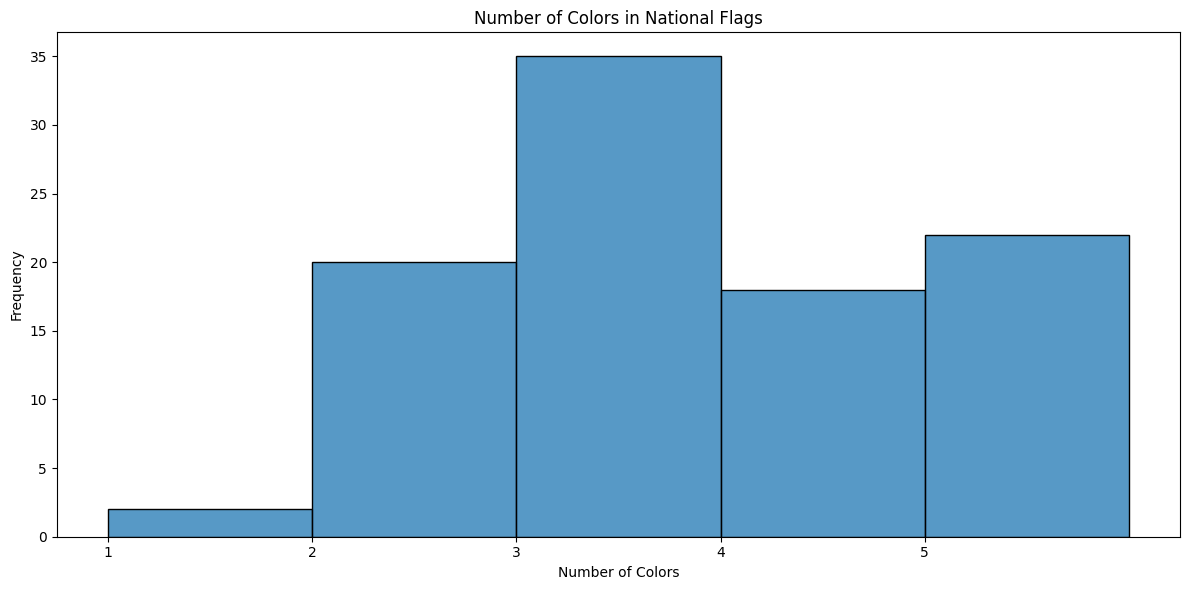

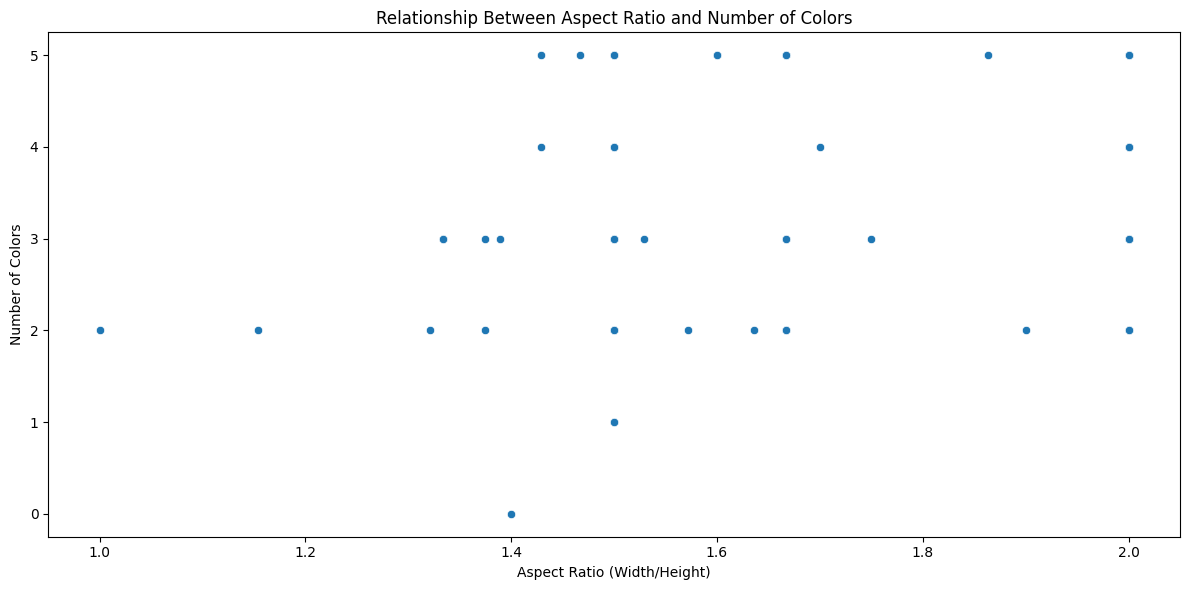

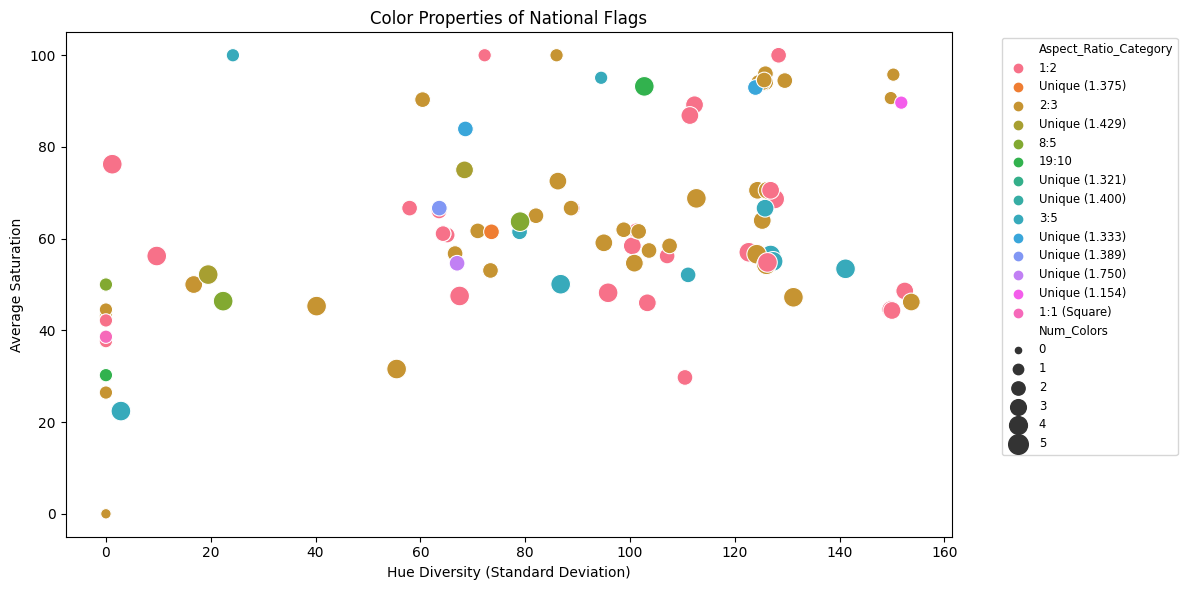

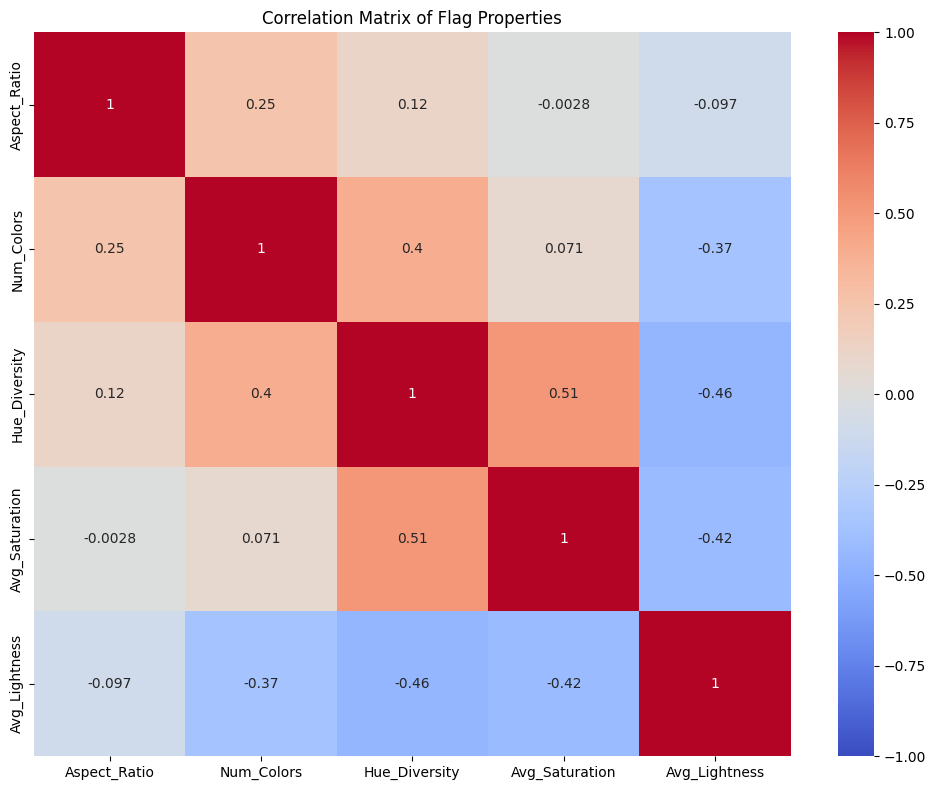

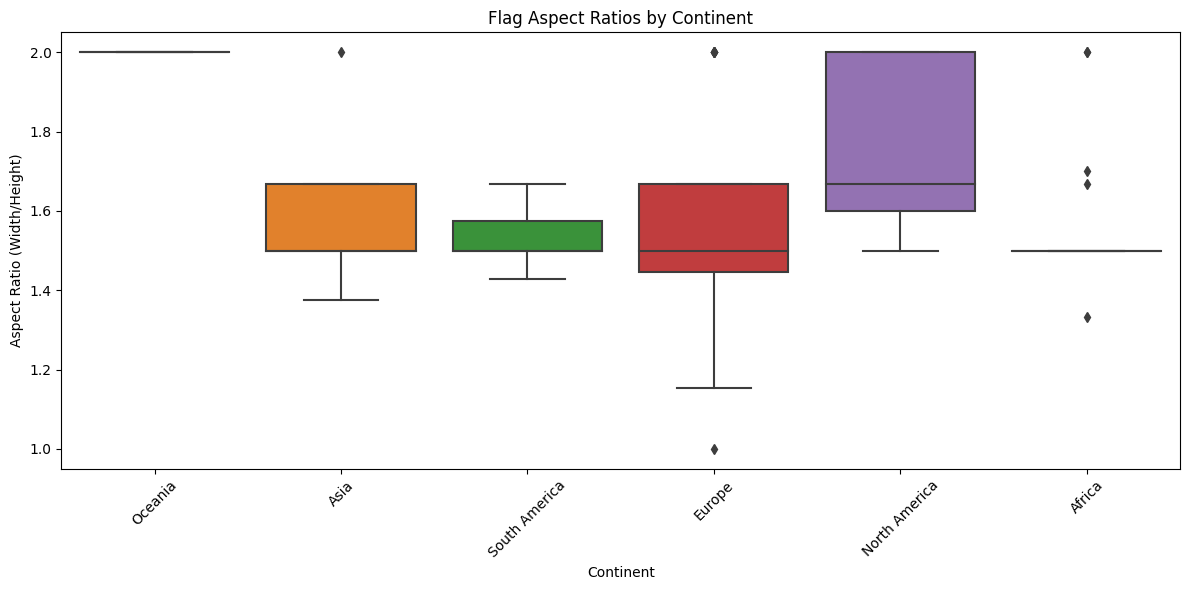

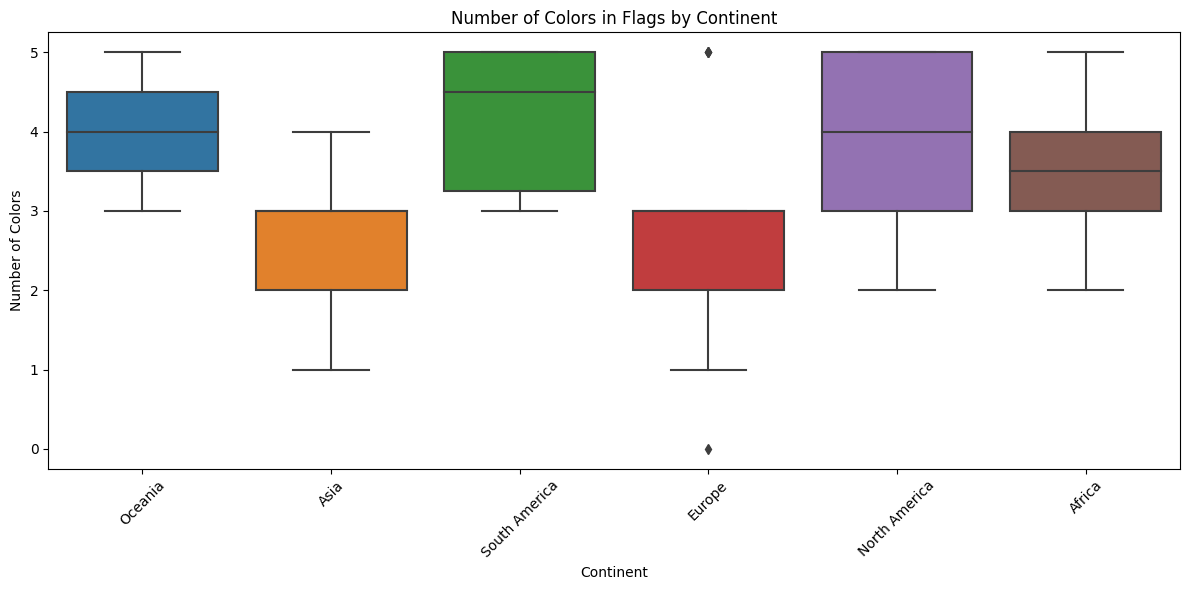

In [ ]:
def generate_report(flag_directory, continent_mapping=None):
    """Generate a comprehensive analysis report"""
    print("Analyzing flag data...")

    # Check if directory exists
    if not os.path.exists(flag_directory):
        print(f"Error: Directory '{flag_directory}' does not exist.")
        print("Please create this directory and place your SVG flag files inside.")
        return

    # Check if directory contains SVG files
    svg_files = [f for f in os.listdir(flag_directory) if f.endswith('.svg')]
    if not svg_files:
        print(f"Error: No SVG files found in '{flag_directory}'.")
        print("Please add SVG flag files to this directory.")
        return

    df = analyze_flag_dataset(flag_directory)

    if df.empty:
        print("No valid flag data found.")
        return

    print(f"Analyzed {len(df)} flags successfully.")

    # Basic statistics
    print("\n--- Basic Statistics ---")
    print(df.describe())

    # Aspect ratio analysis
    print("\n--- Aspect Ratio Analysis ---")
    ratio_counts = analyze_aspect_ratios(df)
    print(ratio_counts)

    # Color analysis
    print("\n--- Color Analysis ---")
    correlation_matrix = analyze_color_properties(df)
    print(correlation_matrix)

    # Continent analysis if mapping provided
    if continent_mapping:
        print("\n--- Continental Patterns ---")
        try:
            continent_stats = analyze_continent_patterns(df, continent_mapping)
            if not continent_stats.empty:
                print(continent_stats)
            else:
                print("Continental analysis could not be performed.")
        except Exception as e:
            print(f"Error in continental analysis: {e}")

    # Outlier analysis
    print("\n--- Unusual Flags ---")
    outliers = identify_outliers(df)
    for category, data in outliers.items():
        print(f"\n{category}:")
        print(data)

    # Save the full dataset
    df.to_csv('flag_analysis_results.csv', index=False)
    print("\nAnalysis complete. Results saved to CSV and visualizations saved as PNG files.")

    return df, outliers

# Example usage
if __name__ == "__main__":
    # Sample continent mapping (you would need to provide the full mapping)
    with open("/kaggle/input/country-flags/continent.json", 'r') as f:
        continent_mapping = json.load(f)

    # Directory containing SVG flag files
    flag_directory = "/kaggle/input/country-flags/selected_svg_images"

    # Run the analysis
    try:
        generate_report(flag_directory, continent_mapping)
    except Exception as e:
        print(f"Error during analysis: {e}")
        import traceback
        traceback.print_exc()

# Textual Analysis

In [ ]:
#!pip install sentence-transformers

Loading model: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed China_Peoples_Republic_of_China's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Europe's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Antigua_and_Barbuda's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed French_Guiana's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Algeria's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Italy's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Finland's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Belize's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Grenada's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Canada's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Botswana's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Iran_Islamic_Republic_of's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Central_African_Republic's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Gambia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Gabon's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Colombia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Faroe_Islands's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Albania's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Eritrea's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Cape_Verde's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Dominica's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Western_Sahara's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Spain's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Brazil's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Argentina's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Egypt's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Isle_of_Man's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Congo_the_Democratic_Republic_of_the's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Croatia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Ecuador's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Guyana's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Brunei_Darussalam's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Cuba's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Equatorial_Guinea's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Georgia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Dominican_Republic's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Azerbaijan's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Anguilla's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Guinea-Bissau's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Belarus's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed United_Arab_Emirates's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Iraq's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Czech_Republic's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed American_Samoa's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Guinea's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Guernsey's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bermuda's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Belgium's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Ireland's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bulgaria's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Denmark's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Guadeloupe's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Barbados's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Guatemala's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bosnia_and_Herzegovina's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Greenland's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Cte_dIvoire's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Andorra's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bahamas's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Israel's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Chile's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Estonia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Indonesia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Switzerland's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Austria's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed India's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bahrain's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bolivia_Plurinational_State_of's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Djibouti's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Cameroon's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Micronesia_Federated_States_of's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Haiti's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed land_Islands's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Saint_Barthlemy's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Gibraltar's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Cyprus's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Fiji's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Benin's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Hong_Kong's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Burkina_Faso's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bhutan's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Ethiopia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Honduras's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Cook_Islands's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Falkland_Islands_Malvinas's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed France's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Jersey's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Afghanistan's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Guam's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Costa_Rica's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Ghana's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Hungary's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Curaao's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Greece's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Burundi's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Republic_of_the_Congo's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Angola's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Aruba's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed United_Kingdom's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Germany's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Armenia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Australia's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Iceland's anthem: (384,)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processed Bangladesh's anthem: (384,)


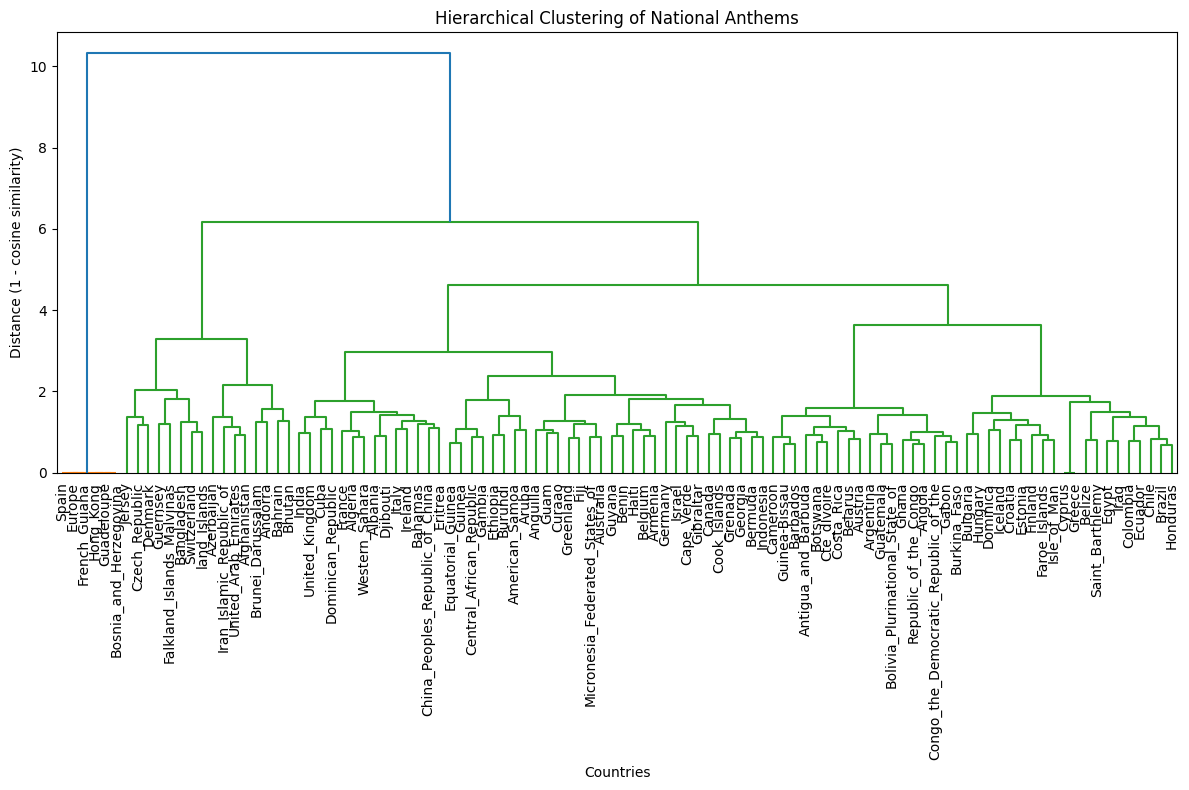

Dendrogram saved to ./anthem_analysis/anthem_dendrogram.png


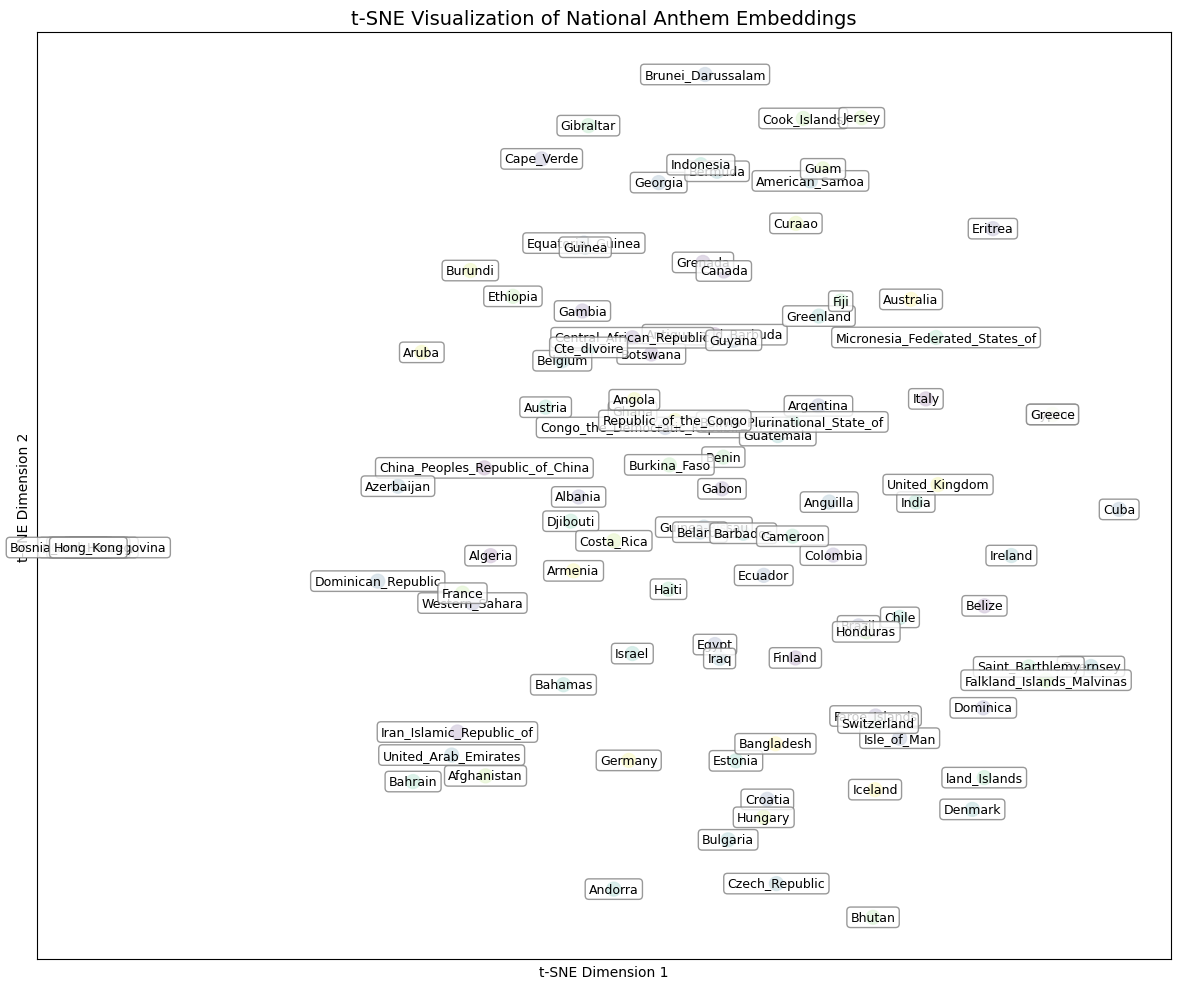

Improved t-SNE plot saved to ./anthem_analysis/anthem_tsne_improved.png
Similarity table saved to ./anthem_analysis/anthem_similarity_table.png
Analysis complete! All visualizations saved to ./anthem_analysis


In [ ]:
from sentence_transformers import SentenceTransformer
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram, linkage

# Function to read anthem files and create embeddings
def create_anthem_embeddings(anthems_directory, model_name='all-MiniLM-L6-v2'):
    print(f"Loading model: {model_name}")
    model = SentenceTransformer(model_name)

    anthem_embeddings = {}

    # Loop through each file in the directory
    for filename in os.listdir(anthems_directory):
        if filename.endswith(".txt"):
            country = filename.replace(".txt", "")

            # Read the anthem text from file
            file_path = os.path.join(anthems_directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                anthem_text = file.read()

            # Generate embedding
            embedding = model.encode(anthem_text)
            anthem_embeddings[country] = embedding

            print(f"Processed {country}'s anthem: {embedding.shape}")

    return anthem_embeddings

# Calculate similarity matrix
def calculate_similarity_matrix(embeddings):
    countries = list(embeddings.keys())
    embedding_array = np.array([embeddings[country] for country in countries])

    # Normalize the embeddings
    norms = np.linalg.norm(embedding_array, axis=1, keepdims=True)
    normalized_embeddings = embedding_array / norms

    # Calculate cosine similarity
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

    return similarity_matrix, countries

# Create hierarchical clustering dendrogram
def plot_anthem_dendrogram(similarity_matrix, countries, output_file="anthem_dendrogram.png"):
    plt.figure(figsize=(12, 8))

    # Convert similarity to distance matrix
    # (1 - similarity) since higher similarity = lower distance
    distance_matrix = 1 - similarity_matrix

    # Perform hierarchical/agglomerative clustering
    Z = linkage(distance_matrix, 'ward')

    # Plot dendrogram
    dendrogram(Z, labels=countries, leaf_rotation=90, leaf_font_size=10)
    plt.title('Hierarchical Clustering of National Anthems')
    plt.xlabel('Countries')
    plt.ylabel('Distance (1 - cosine similarity)')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()
    plt.close()
    print(f"Dendrogram saved to {output_file}")

# Create an improved 2D scatter plot with t-SNE
def plot_improved_tsne(embeddings, output_file="anthem_tsne_improved.png"):
    countries = list(embeddings.keys())
    embedding_array = np.array([embeddings[country] for country in countries])

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(countries)-1) if len(countries) < 30 else 30)
    reduced_data = tsne.fit_transform(embedding_array)

    # Create a DataFrame
    df = pd.DataFrame({
        'Country': countries,
        'x': reduced_data[:, 0],
        'y': reduced_data[:, 1]
    })

    # Create color map - this will visually distinguish different clusters
    # The clusters are determined by x and y positions

    # Plot with better styling
    plt.figure(figsize=(12, 10), facecolor='white')
    plt.scatter(df['x'], df['y'], s=100, c=np.arange(len(countries)), cmap='viridis', alpha=0.8)

    # Add better text labels with background
    for i, row in df.iterrows():
        plt.annotate(row['Country'],
                    (row['x'], row['y']),
                    fontsize=9,
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='gray', alpha=0.8),
                    xytext=(0, 0),
                    textcoords='offset points')

    plt.title('t-SNE Visualization of National Anthem Embeddings', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Remove axes ticks as they're meaningless in t-SNE
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Improved t-SNE plot saved to {output_file}")

# Function to create a top-similar anthems table for each country
def create_similarity_table(similarity_matrix, countries, top_n=3, output_file="anthem_similarity_table.png"):
    # Prepare data for the table
    table_data = []
    for i, country in enumerate(countries):
        # Get similarities for this country (excluding self-similarity)
        sims = [(countries[j], similarity_matrix[i, j]) for j in range(len(countries)) if i != j]
        # Sort by similarity (highest first)
        sims.sort(key=lambda x: x[1], reverse=True)
        # Take top N
        top_similar = sims[:top_n]
        # Format for table
        row = [country] + [f"{c} ({s:.2f})" for c, s in top_similar]
        table_data.append(row)

    # Convert to pandas DataFrame for easier manipulation
    columns = ['Country'] + [f'Similar {i+1}' for i in range(top_n)]
    df = pd.DataFrame(table_data, columns=columns)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, len(countries)*0.4))

    # Hide axes
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center',
                     cellLoc='center', colColours=['#f2f2f2']*len(df.columns))

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Adjust layout
    plt.title("Most Similar National Anthems by Country")
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Similarity table saved to {output_file}")

# Main function to run everything
def analyze_anthem_embeddings(anthems_directory, output_dir="./anthem_analysis"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create embeddings
    embeddings = create_anthem_embeddings(anthems_directory)

    # Save embeddings
    with open(os.path.join(output_dir, 'anthem_embeddings.pkl'), 'wb') as f:
        import pickle
        pickle.dump(embeddings, f)

    # Calculate similarity matrix
    similarity_matrix, countries = calculate_similarity_matrix(embeddings)


    # 1. Hierarchical clustering dendrogram
    plot_anthem_dendrogram(similarity_matrix, countries,
                          output_file=os.path.join(output_dir, "anthem_dendrogram.png"))

    # 2. Improved t-SNE visualization
    plot_improved_tsne(embeddings,
                     output_file=os.path.join(output_dir, "anthem_tsne_improved.png"))

    # 3. Similarity table
    create_similarity_table(similarity_matrix, countries,
                           output_file=os.path.join(output_dir, "anthem_similarity_table.png"))

    print(f"Analysis complete! All visualizations saved to {output_dir}")
    return embeddings, similarity_matrix, countries

# Example usage
if __name__ == "__main__":
    # Change this to your actual directory path
    anthems_directory = "/kaggle/input/country-flags/translations"
    analyze_anthem_embeddings(anthems_directory)

In [ ]:
#!pip install librosa numpy matplotlib scikit-learn pandas scipy

# Audio Analysis

In [ ]:
import librosa
import numpy as np
import os

def extract_audio_features(audio_file, n_mfcc=13, n_chroma=12):
    """Extract audio features from an MP3 file"""
    try:
        # Load audio file with librosa
        y, sr = librosa.load(audio_file, sr=None)

        # Extract various audio features
        features = []

        # MFCCs (timbre)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features.append(np.mean(mfccs, axis=1))
        features.append(np.std(mfccs, axis=1))

        # Chroma features (harmony/pitch)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features.append(np.mean(chroma, axis=1))
        features.append(np.std(chroma, axis=1))

        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

        features.append(np.mean(spectral_centroid))
        features.append(np.std(spectral_centroid))
        features.append(np.mean(spectral_bandwidth))
        features.append(np.std(spectral_bandwidth))
        features.append(np.mean(spectral_rolloff))
        features.append(np.std(spectral_rolloff))

        # Tempo estimation
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        features.append(tempo)

        # Flatten and concatenate all features
        feature_vector = np.concatenate([f.flatten() for f in features])
        return feature_vector

    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

In [ ]:
def create_audio_embeddings(audio_directory):
    """Create embeddings from anthem audio files"""
    audio_embeddings = {}

    for filename in os.listdir(audio_directory):
        if filename.endswith(".mp3"):
            try:
                country = filename.replace(".mp3", "")
                file_path = os.path.join(audio_directory, filename)

                # Extract audio features
                features = extract_audio_features(file_path)

                if features is not None:
                    # Normalize the features
                    norm = np.linalg.norm(features)
                    if norm > 0:
                        features = features / norm

                    audio_embeddings[country] = features
                    print(f"Processed {country}'s audio anthem: {features.shape}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    return audio_embeddings

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_audio_embeddings(audio_embeddings, output_file="audio_anthem_tsne.png"):
    """Create t-SNE visualization of audio embeddings"""
    countries = list(audio_embeddings.keys())
    embedding_array = np.array([audio_embeddings[country] for country in countries])

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(countries)-1) if len(countries) < 30 else 30)
    reduced_data = tsne.fit_transform(embedding_array)

    # Create plot
    plt.figure(figsize=(12, 10), facecolor='white')
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=100, alpha=0.8)

    # Add country labels
    for i, country in enumerate(countries):
        plt.annotate(country,
                    (reduced_data[i, 0], reduced_data[i, 1]),
                    fontsize=9,
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='gray', alpha=0.8))

    plt.title('t-SNE Visualization of National Anthem Audio Embeddings', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()
    plt.close()
    print(f"Audio embedding visualization saved to {output_file}")

In [ ]:
def calculate_audio_similarity_matrix(audio_embeddings):
    """Calculate cosine similarity matrix for audio embeddings"""
    countries = list(audio_embeddings.keys())
    embedding_array = np.array([audio_embeddings[country] for country in countries])

    # Calculate cosine similarity
    # (Higher values = more similar)
    similarity_matrix = np.zeros((len(countries), len(countries)))

    for i in range(len(countries)):
        for j in range(len(countries)):
            # Compute cosine similarity
            dot_product = np.dot(embedding_array[i], embedding_array[j])
            norm_i = np.linalg.norm(embedding_array[i])
            norm_j = np.linalg.norm(embedding_array[j])

            if norm_i > 0 and norm_j > 0:
                similarity_matrix[i, j] = dot_product / (norm_i * norm_j)
            else:
                similarity_matrix[i, j] = 0

    return similarity_matrix, countries

In [ ]:
def analyze_anthem_audio(text_embeddings, audio_directory, output_dir="/kaggle/working/anthem_analysis"):
    """Run the complete audio anthem analysis"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create audio embeddings
    print("Creating audio embeddings...")
    audio_embeddings = create_audio_embeddings(audio_directory)

    # Save embeddings
    with open(os.path.join(output_dir, 'audio_embeddings.pkl'), 'wb') as f:
        pickle.dump(audio_embeddings, f)

    # Visualize audio embeddings
    visualize_audio_embeddings(audio_embeddings,
                               output_file=os.path.join(output_dir, "audio_anthem_tsne.png"))

    # Calculate audio similarity matrix
    audio_similarity, audio_countries = calculate_audio_similarity_matrix(audio_embeddings)


    print("Audio analysis complete! Results saved to", output_dir)
    return text_embeddings, audio_embeddings

Creating audio embeddings...


<ipython-input-17-8ba77044f749>:38: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]


Processed Azerbaijan's audio anthem: (57,)
Processed Iran_Islamic_Republic_of's audio anthem: (57,)
Processed Guinea-Bissau's audio anthem: (57,)
Processed China_Peoples_Republic_of_China's audio anthem: (57,)
Processed Barbados's audio anthem: (57,)
Processed Bermuda's audio anthem: (57,)
Processed Bolivia_Plurinational_State_of's audio anthem: (57,)
Processed Dominica's audio anthem: (57,)
Processed France's audio anthem: (57,)
Processed Dominican_Republic's audio anthem: (57,)
Processed Finland's audio anthem: (57,)
Processed Ecuador's audio anthem: (57,)
Processed Isle_of_Man's audio anthem: (57,)
Processed Belize's audio anthem: (57,)
Processed Colombia's audio anthem: (57,)
Processed Bahrain's audio anthem: (57,)
Processed Brunei_Darussalam's audio anthem: (57,)
Processed Cook_Islands's audio anthem: (57,)
Processed Micronesia_Federated_States_of's audio anthem: (57,)
Processed Spain's audio anthem: (57,)
Processed Eritrea's audio anthem: (57,)
Processed Cameroon's audio anthem: 

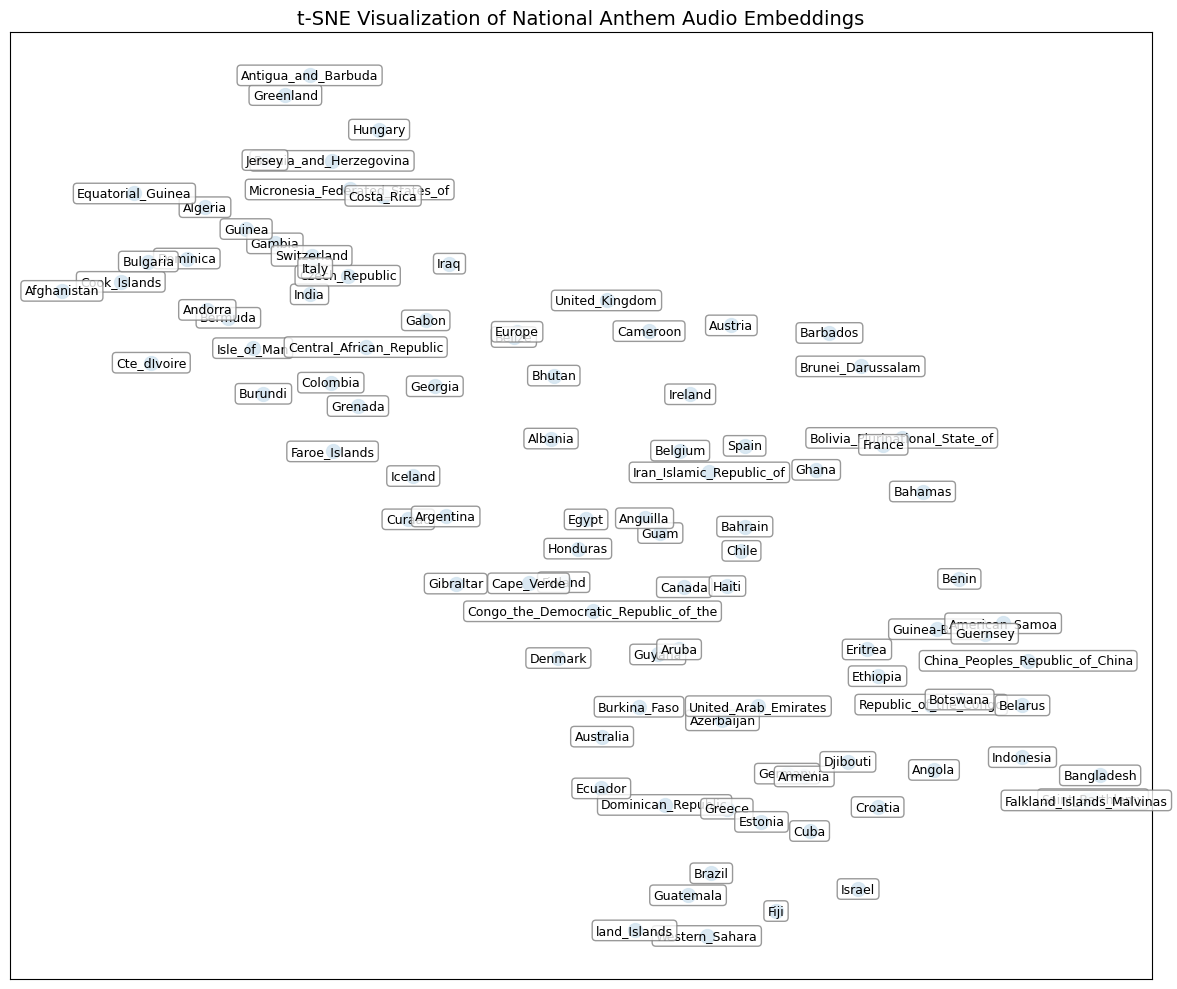

Audio embedding visualization saved to /kaggle/working/anthem_analysis/audio_anthem_tsne.png
Audio analysis complete! Results saved to /kaggle/working/anthem_analysis


In [ ]:
if __name__ == "__main__":
    # Change these to your actual directory paths
    audio_directory = "/kaggle/input/country-flags/anthems"

    # Run the analysis
    text_embeddings, audio_embeddings = analyze_anthem_audio(embeddings, audio_directory)

# Multimodal Correlation

### To see for Multimodal correlation , I tried to match anthems(audio) with written versions.
### The result is stored in `text_audio_matching.png`

In [ ]:
def match_text_and_audio_embeddings(text_embeddings, audio_embeddings, output_file="text_audio_matching.png"):
    """Find correspondences between text and audio embeddings of different dimensions"""
    # Get countries present in both sets
    common_countries = sorted(set(text_embeddings.keys()) & set(audio_embeddings.keys()))

    if not common_countries:
        print("No common countries found between text and audio embeddings.")
        return

    print(f"Found {len(common_countries)} countries with both text and audio embeddings")

    # First, create similarity matrices for each modality
    text_sim_matrix = np.zeros((len(common_countries), len(common_countries)))
    audio_sim_matrix = np.zeros((len(common_countries), len(common_countries)))

    # Get embeddings for common countries
    text_data = [text_embeddings[country] for country in common_countries]
    audio_data = [audio_embeddings[country] for country in common_countries]

    # Calculate text similarity matrix
    for i in range(len(common_countries)):
        for j in range(len(common_countries)):
            # Compute cosine similarity
            dot_product = np.dot(text_data[i], text_data[j])
            norm_i = np.linalg.norm(text_data[i])
            norm_j = np.linalg.norm(text_data[j])

            if norm_i > 0 and norm_j > 0:
                text_sim_matrix[i, j] = dot_product / (norm_i * norm_j)
            else:
                text_sim_matrix[i, j] = 0

    # Calculate audio similarity matrix
    for i in range(len(common_countries)):
        for j in range(len(common_countries)):
            # Compute cosine similarity
            dot_product = np.dot(audio_data[i], audio_data[j])
            norm_i = np.linalg.norm(audio_data[i])
            norm_j = np.linalg.norm(audio_data[j])

            if norm_i > 0 and norm_j > 0:
                audio_sim_matrix[i, j] = dot_product / (norm_i * norm_j)
            else:
                audio_sim_matrix[i, j] = 0

    # Now we can compare the similarity patterns
    # For each country, we check how similar its relative position is in both spaces
    matching_scores = np.zeros((len(common_countries), len(common_countries)))

    for i in range(len(common_countries)):
        for j in range(len(common_countries)):
            # For text country i and audio country j, we compare their similarity patterns
            # by calculating the correlation between their similarity vectors
            text_pattern = text_sim_matrix[i]
            audio_pattern = audio_sim_matrix[j]

            # Calculate correlation coefficient
            correlation = np.corrcoef(text_pattern, audio_pattern)[0, 1]

            # Handle NaN cases
            if np.isnan(correlation):
                correlation = 0

            # Store as a similarity score (higher is better)
            matching_scores[i, j] = correlation

    # Create matching visualization
    plt.figure(figsize=(14, 12))
    plt.imshow(matching_scores, cmap='viridis')
    plt.colorbar(label='Pattern Similarity (higher = better match)')
    plt.xticks(range(len(common_countries)), common_countries, rotation=90)
    plt.yticks(range(len(common_countries)), common_countries)
    plt.xlabel('Audio Anthems')
    plt.ylabel('Text Anthems')
    plt.title('Matching Between Text and Audio Anthem Similarity Patterns')

    # Mark diagonal (perfect matches) with white squares
    for i in range(len(common_countries)):
        plt.plot(i, i, 's', color='white', markersize=8)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()
    plt.close()

    # Find top matches for each text
    matches = []
    for i, country in enumerate(common_countries):
        # Get correlation scores from this text to all audios
        scores = [(common_countries[j], matching_scores[i, j]) for j in range(len(common_countries))]
        # Sort by score (descending)
        scores.sort(key=lambda x: x[1], reverse=True)
        # Add top 3 matches
        matches.append((country, scores[:3]))

    # Save matches to text file
    with open(output_file.replace(".png", ".txt"), 'w') as f:
        f.write("Text-Audio Anthem Matching Results:\n\n")
        for country, top_matches in matches:
            f.write(f"Text anthem for {country} best matches with audio anthems:\n")
            for match_country, score in top_matches:
                f.write(f"  - {match_country}: similarity score = {score:.4f}\n")
            f.write("\n")

        # Calculate overall matching accuracy
        direct_match_count = 0
        for i, country in enumerate(common_countries):
            if matches[i][1][0][0] == country:  # If top match is same country
                direct_match_count += 1

        accuracy = direct_match_count / len(common_countries) if common_countries else 0
        f.write(f"\nOverall matching accuracy: {accuracy:.2%} ({direct_match_count}/{len(common_countries)})")

    print(f"Text-audio matching visualization saved to {output_file}")
    print(f"Text-audio matching results saved to {output_file.replace('.png', '.txt')}")

    return matching_scores, common_countries

Found 100 countries with both text and audio embeddings


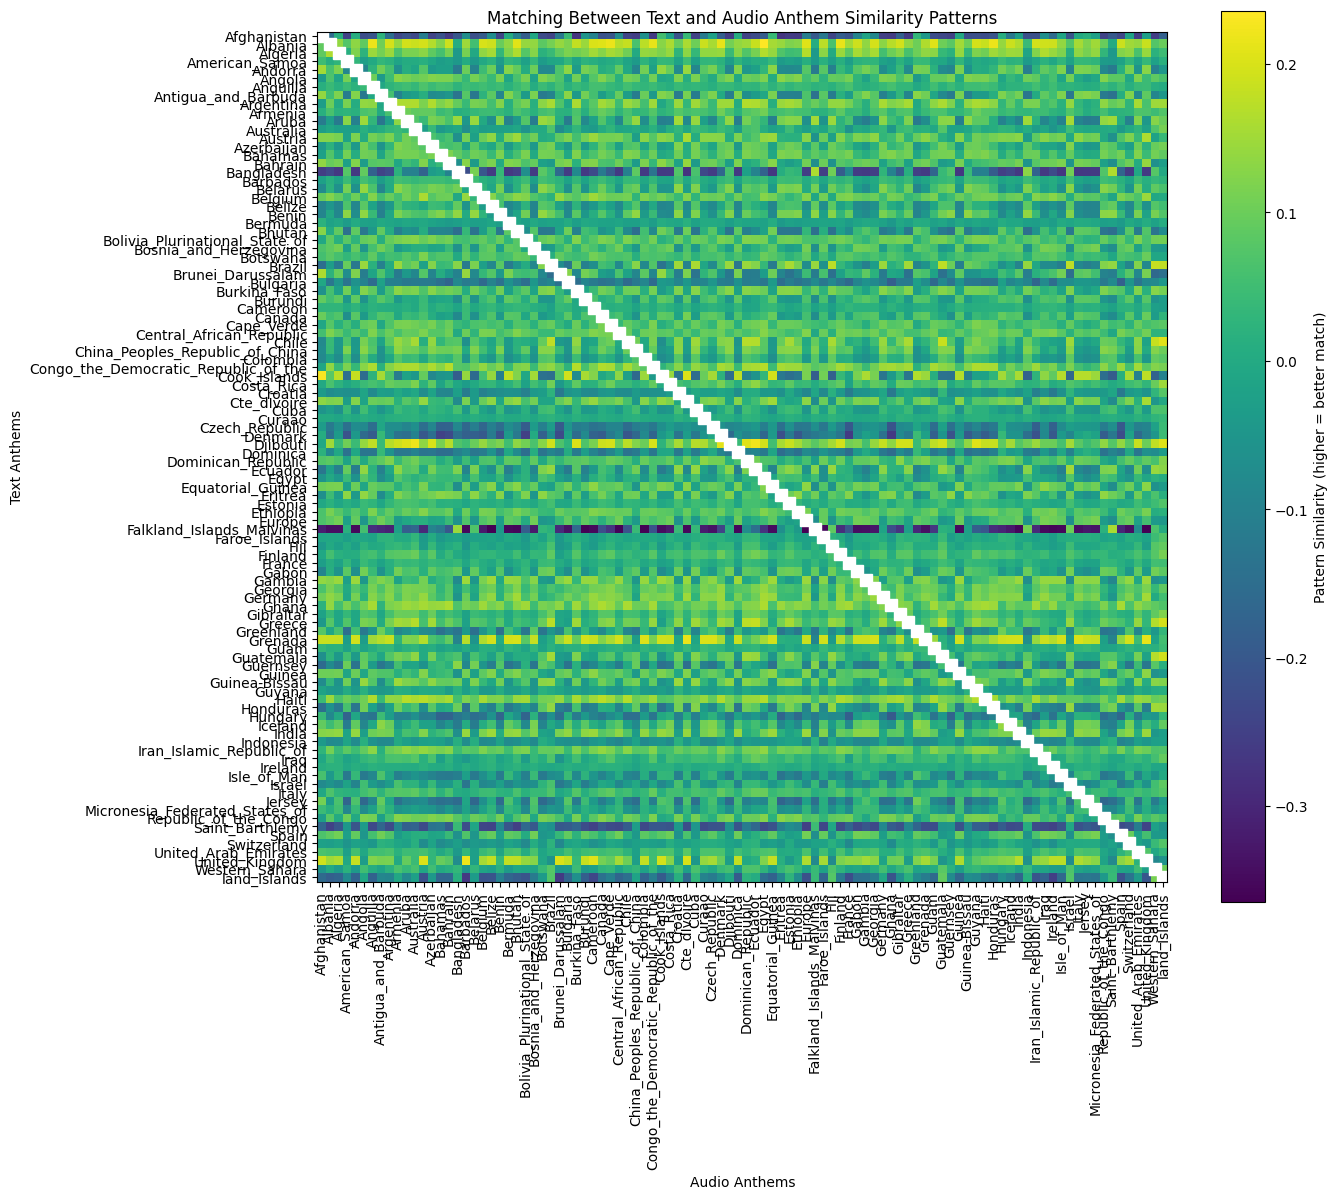

Text-audio matching visualization saved to /kaggle/working/text_audio_matching.png
Text-audio matching results saved to /kaggle/working/text_audio_matching.txt


(array([[ 0.12186716, -0.15266968,  0.01194677, ..., -0.0257292 ,
         -0.25390499, -0.18167653],
        [ 0.08888332,  0.21446571,  0.13786895, ...,  0.1840222 ,
          0.07576172,  0.09950729],
        [ 0.0896854 ,  0.16092678,  0.13086474, ...,  0.14394718,
          0.0202031 ,  0.04623511],
        ...,
        [ 0.19243505,  0.15021602,  0.16140662, ...,  0.21934635,
         -0.08707381, -0.05641734],
        [-0.05332956, -0.00087875, -0.03608664, ..., -0.02700057,
          0.08808409,  0.09982092],
        [-0.15651784, -0.18179618, -0.17030943, ..., -0.20068089,
          0.1127581 ,  0.16481511]]),
 ['Afghanistan',
  'Albania',
  'Algeria',
  'American_Samoa',
  'Andorra',
  'Angola',
  'Anguilla',
  'Antigua_and_Barbuda',
  'Argentina',
  'Armenia',
  'Aruba',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bermuda',
  'Bhutan',
  'Bolivia_Plurinational_State_of

In [ ]:
# Match text and audio embeddings
match_text_and_audio_embeddings(embeddings, audio_embeddings,
                                   output_file=os.path.join("/kaggle/working/", "text_audio_matching.png"))
